## Libraries

In [1]:
!pip install keras-core

In [2]:
!pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 50.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 94.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 3.7 MB/s eta 0:00:00
   ━

In [3]:
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [5]:
import os
import shutil
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import tensorflow_models as tfm
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, Reshape, Concatenate
from keras.layers import LSTM, Flatten, Dropout, MultiHeadAttention, Bidirectional, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
import time

2024-12-17 07:35:39.384905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734420939.407540      23 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734420939.414458      23 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
print(tf.__version__)

2.18.0


In [7]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
else:
    print('Using CPU')

Using GPU


In [8]:
np.random.seed(42)

In [9]:
%matplotlib inline

## 0. Context

Here, we will use transformer models, attention layers, bidirectional layers, and the rest of the algorithms studied so far to build and train a grammatical paraphrasing classifier. Paraphrasing refers to using different expressions or words to express the same thing. To clarify this point, let's look at a paraphrasing example:

I'm going to go from Madrid to Barcelona.
I'm going to travel to Barcelona from Madrid.

However, it can happen that using the same words, the meaning is completely different. Here is an example of non-paraphrase where the same words are used but the meaning changes radically:

I'm going to travel from Vitoria to Madrid.
I'm going to travel from Madrid to Vitoria.

The neural architecture that we design, train, and test must be able to distinguish whether two sentences have the same meaning or not.

Although it may seem like a game, the complexity and scientific challenge posed is very high and was completely out of reach until just a decade ago. On the one hand, it is necessary to have a high degree of knowledge of the lexicon of the language, and on the other hand, it is necessary to have a deep understanding of how context, grammar, and long-distance relationships between words generate the abstract meaning of a sentence. The applications of an architecture capable of doing this are many, such as grammatical correction systems, text simplification systems, summary generation systems, etc.

Here, the PAWS (Paraphrase Adversaries from Word Scrambling) database has been chosen, specifically the PAW-Wiki version. The motivation of this database is to provide an existing paraphrase identification dataset to train specific models. It consists of 49,401 training paraphrases, 8,000 for development, and 8,000 for testing.

## 1. Data loading, preprocessing, visualization

To prepare the data, I will:

1. Download the paws_wiki dataset using tensorflow_datasets. (https://www.tensorflow.org/datasets/catalog/paws_wiki). 
2. Divide it into train, validation, and test sets.
3. Process the objects obtained with tensorflow_datasets appropriately and generate: train_sentence1, train_sentence2, train_labels, val_sentence1, val_sentence2, val_labels, test_sentence1, test_sentence2, and test_labels. These new variables should be lists.
4. Show the first 3 elements of each list. When displaying them, do it in a suitable way, such as in a table or with another method, but something like: phrase_train_sentence1, phrase1_train_sentence 2, train_label
5. Show a table with the dimensions of each object.
6. Show a histogram of the size of the sentences (in the number of words) of train_sentence1.
7. Make sure to include a title and the names of the axes.

In [10]:
# Load dataset
paws_wiki = tfds.load("paws_wiki")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/49401 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.SCQ4EA_1.1.0/paws_wiki-train.…

Generating validation examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.SCQ4EA_1.1.0/paws_wiki-valida…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/incomplete.SCQ4EA_1.1.0/paws_wiki-test.t…

Dataset paws_wiki downloaded and prepared to /root/tensorflow_datasets/paws_wiki/labeled_final_tokenized/1.1.0. Subsequent calls will reuse this data.


I0000 00:00:1734420955.336314      23 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1734420955.337064      23 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
# Separate in train, val and test
paws_wiki_train = paws_wiki['train']
paws_wiki_val = paws_wiki['validation']
paws_wiki_test = paws_wiki['test']

In [12]:
# Separate training dataset
train_sentence1 = []
train_sentence2 = []
train_labels = []

# Decode phrases and add to relevant variables
for element in paws_wiki_train:
    train_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    train_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    train_labels.append(element['label'].numpy())
    
# Show that variables are lists
print('Variable type train_sentence1: '+str(type(train_sentence1)))
print('Variable type train_sentence2: '+str(type(train_sentence2)))
print('Variable type label: '+str(type(train_labels)))

Variable type train_sentence1: <class 'list'>
Variable type train_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [13]:
# Separate validation dataset
val_sentence1 = []
val_sentence2 = []
val_labels = []

# Decode phrases and add to relevant variables
for element in paws_wiki_val:
    val_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    val_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    val_labels.append(element['label'].numpy())

# Show that variables are lists
print('Variable type val_sentence1: '+str(type(val_sentence1)))
print('Variable type val_sentence2: '+str(type(val_sentence2)))
print('Variable type label: '+str(type(val_labels)))

Variable type val_sentence1: <class 'list'>
Variable type val_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [14]:
# Separate test dataset
test_sentence1 = []
test_sentence2 = []
test_labels = []

for element in paws_wiki_test:
    test_sentence1.append(element['sentence1'].numpy().decode('utf-8'))
    test_sentence2.append(element['sentence2'].numpy().decode('utf-8'))
    test_labels.append(element['label'].numpy())
    
print('Variable type test_sentence1: '+str(type(test_sentence1)))
print('Variable type test_sentence2: '+str(type(test_sentence2)))
print('Variable type label: '+str(type(test_labels)))

Variable type test_sentence1: <class 'list'>
Variable type test_sentence2: <class 'list'>
Variable type label: <class 'list'>


In [15]:
pd.set_option('display.max_colwidth', None)

# Show first 3 elements of training set
train_set = [train_sentence1, train_sentence2, train_labels]

df_train = pd.DataFrame(index=range(0,3), columns=['train_sentence1', 'train_sentence2', 'train_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_train.loc[el, df_train.columns[set]] = train_set[set][el]
        else:
            df_train.loc[el, df_train.columns[set]] = train_set[set][el]

df_train.head()

,train_sentence1,train_sentence2,train_label
0,"Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany .",Hugo Käch died on 31 December 2003 in Flurlingen near Schaffhausen .,0
1,"In 2013 Peter married Anna Barattin while Julia is married to Nicholas Furiuele , both are members of the band Shantih Shantih .","Peter Anna Barattin married in 2013 while Julia was married to Nicholas Furiuele , both of whom are members of the band Shantih Shantih .",1
2,"The recent Sierra Leone Civil War was secular in nature featuring members of Tribal , Muslim , and Christian faiths fighting on both sides of the conflict .","The recent civil war in Sierra Leone was secular in nature , with members of Christian , Muslim , and tribal faith fighting on both sides of the conflict .",1


In [16]:
# Show first 3 elements of validation set
val_set = [val_sentence1, val_sentence2, val_labels]

df_val = pd.DataFrame(index=range(0,3), columns=['val_sentence1', 'val_sentence2', 'val_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_val.loc[el, df_val.columns[set]] = val_set[set][el]
        else:
            df_val.loc[el, df_val.columns[set]] = val_set[set][el]

df_val.head()

,val_sentence1,val_sentence2,val_label
0,The plant may have some medical properties and has been used in traditional medicine in South Asia and in traditional Chinese medicine .,The plant can have some medical properties and has been used in traditional Chinese medicine in South Asia and traditional medicine .,0
1,"This was recorded in two separate inscriptions from his corpse hill Medinet Habu , which are physically long and somewhat different from one another .","This was recorded in two long inscriptions from his body horde Medinet Habu , which are physically separate and somewhat different from one another .",0
2,"Malcolm Fraser , who had defeated Whitlam in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement .","Whitlam , who had defeated Malcolm Fraser in a landslide at the federal election in December 1975 , offered Egerton the knighthood for serving the trade union movement .",0


In [17]:
# Show first 3 elements of test set
test_set = [test_sentence1, test_sentence2, test_labels]

df_test = pd.DataFrame(index=range(0,3), columns=['test_sentence1', 'test_sentence2', 'test_label'])

for el in range(0,3):
    for set in range(0,3):
        if set <2 :
            df_test.loc[el, df_test.columns[set]] = test_set[set][el]
        else:
            df_test.loc[el, df_test.columns[set]] = test_set[set][el]

df_test.head()

,test_sentence1,test_sentence2,test_label
0,"The NRA has referred to the NAGR leader , Dudley Brown , as '' Al Sharpton of the gun movement `` .",The NRA has referred to the NAGR - leader Al Sharpton as '' the Dudley Brown of the gun movement `` .,0
1,The layout of Belmont is similar to that of Twin Pines park and other parks in Davey Glen Park .,The Belmont layout is similar to that of Twin Pines Park and other parks in Davey Glen Park .,1
2,"Road access to Island Harbour is via Mill Lane , which connects to North Fairlee Road ( A3054 ) .","The access to North Fairlee Road is via Mill Lane , which connects to the Island Harbour ( A3054 ) .",0


In [18]:
# Show number of elements in each list
objects = [train_sentence1, train_sentence2, train_labels, val_sentence1, val_sentence2, val_labels, test_sentence1, test_sentence2, test_labels]
objects_names = ["train_sentence1", "train_sentence2", "train_labels", "val_sentence1", "val_sentence2", "val_labels", "test_sentence1", "test_sentence2", "test_labels"]

for el in range(len(objects)):
    print("Size of "+objects_names[el]+": "+str(len(objects[el])))

Size of train_sentence1: 49401
Size of train_sentence2: 49401
Size of train_labels: 49401
Size of val_sentence1: 8000
Size of val_sentence2: 8000
Size of val_labels: 8000
Size of test_sentence1: 8000
Size of test_sentence2: 8000
Size of test_labels: 8000


Before showing the histogram with the number of words in each phrase of train_sentence1, I'm going to remove characters that are not spaces, letters, or numbers. The reason is that to count the number of words in each phrase I'm going to use .split(). If I do it without removing characters that are not spaces, letters, or numbers, the split will separate those characters and they will be counted as words later. Let's see an example of a phrase before removing those characters:

In [19]:
# Show a phrase before removing characters that are not spaces, letters, or numbers
train_sentence1[0]

'Hugo Käch died on December 31 , 2003 in Schaffhausen near Flurlingen , Germany .'

In [20]:
# For each sentence in train_sentence1 get the text
train_sentence1_words = []

for el in range(len(train_sentence1)):
    train_sentence1_words.append(train_sentence1[el])

In [21]:
# Eliminate anything that is not numbres, leters or spaces
train_sentence1_words_clean = []

for el in range(len(train_sentence1_words)):
    train_sentence1_words_clean.append(re.sub(r"[^a-zA-Z0-9_ ]","",train_sentence1_words[el]))

In [22]:
# Count number of words in each sentence, add to a count list
train_sentence1_words_count = []

for el in range(len(train_sentence1_words_clean)):
    train_sentence1_words_count.append(len(train_sentence1_words_clean[el].split()))

In [23]:
# Show a phrase after removing characters that are not spaces, letters, or numbers
train_sentence1_words_clean[0]

'Hugo Kch died on December 31  2003 in Schaffhausen near Flurlingen  Germany '

In [24]:
# Create a dataframe from the list with the number of words per sentence
df_words_train_sentence1 = pd.DataFrame(data=train_sentence1_words_count, index=range(len(train_sentence1_words_count)), columns=['Number_words_train_sentence1'])
df_words_train_sentence1

,Number_words_train_sentence1
0,12
1,21
2,25
3,21
4,16
...,...
49396,19
49397,11
49398,17
49399,22


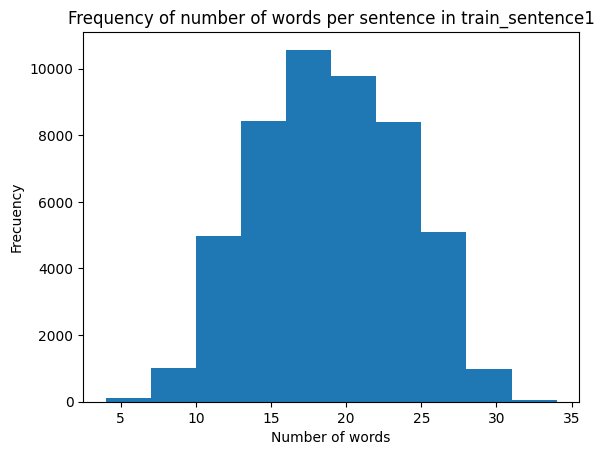

In [25]:
# Show number of words per sentence in train_sentence1
plt.hist(df_words_train_sentence1)
plt.title("Frequency of number of words per sentence in train_sentence1")
plt.xlabel("Number of words")
plt.ylabel("Frecuency")
plt.show()

The frequency of occurrence depends on the size of the bin, but we see that, for the default size of matplotlib.plt, we have about 15-20 words per sentence.

## 1.1. Label processing and tokenization

We will now use the `tf.keras.preprocessing.text.Tokenizer` class from TensorFlow to process the sentences and convert them into numbers, limiting the number of distinct words (vocabulary) to 5,000 words, and using the option oov_token="-OOV-" for out-of-vocabulary words.

In [26]:
# Instantiate and train the tokenizer using train_sentence1 and train_sentence2
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=5000,
    oov_token="-OOV-")

tokenizer.fit_on_texts(train_sentence1+train_sentence2)

In [27]:
# Show one sentence before tokenizing
train_sentence1[1]

'In 2013 Peter married Anna Barattin while Julia is married to Nicholas Furiuele , both are members of the band Shantih Shantih .'

In [28]:
# Tokenize the sentence
token_example = tokenizer.texts_to_sequences(train_sentence1[1].split())
print(token_example)

[[3], [229], [293], [54], [1311], [1], [92], [2618], [7], [54], [9], [1571], [1], [], [245], [21], [275], [5], [2], [244], [3958], [3958], []]


In [29]:
# Detokenize the sentence
print(tokenizer.sequences_to_texts(token_example))

['in', '2013', 'peter', 'married', 'anna', '-OOV-', 'while', 'julia', 'is', 'married', 'to', 'nicholas', '-OOV-', '', 'both', 'are', 'members', 'of', 'the', 'band', 'shantih', 'shantih', '']


In [30]:
# Show some elements of the dictionary
list(tokenizer.__dict__["word_index"])[0:20]

['-OOV-',
 'the',
 'in',
 'and',
 'of',
 'a',
 'is',
 'was',
 'to',
 'by',
 'on',
 'with',
 "''",
 'for',
 'as',
 'he',
 'from',
 'it',
 'his',
 'at']

A tokenizer is a tool that splits texts into smaller units and assigns numerical values to each of those units. It does this by creating a base vocabulary with a specified number of words (this is the role of the `num_words` parameter). The tokenizer is trained on a text, which serves as the training data, so that it selects the words from that text to form the vocabulary. Once trained, the tokenizer can tokenize a text (as demonstrated in the example from the last three cells) and decode it, since each word in the vocabulary has an associated numerical value. Besides the number of words, other important tokenizer parameters include:

`filters`: In natural language texts, there are characters with little or no semantic value. When instantiating the tokenizer, filters are used to remove these characters.  
`lower`: The tokenizer can convert all letters to lowercase to ensure, for instance, that words at the beginning of a sentence (starting with an uppercase letter) don't get a different numerical value from the same word in the middle of the sentence, written entirely in lowercase. By default, lower is set to True.  
`split`: Similar to the split() method of a regular Python string. It specifies which character will be used to split sentences into words. By default, it's a space.  
`char_level`: If set to False (default), sentences are split into words. If set to True, they are split into characters. In our case, we leave it at the default.  
`oov_token`: The token value for words not present in the dictionary. In our case, it's "-OOV-".  
`analyzer`: Processes the text and converts it into a stream of tokens. In our case, this is not used.

## 1.2. Preparing data for training

Let’s prepare our data for training by:

1. Tokenizing `train_sentence1`, `train_sentence2`, `val_sentence1`, `val_sentence2`, `test_sentence1`, and `test_sentence2`.
2. Calculating the length of the longest sentence in train_sentence1 and train_sentence2.
3. Using the function `preprocessing.sequence.pad_sequences` with zeros so that all tokenized sentences have the same length, equal to the length of the longest sentence.
4. Converting the variables `Y_train`, `y_val`, and `y_test` into `numpy.arrays`.

In [31]:
# Tokenize sets
tokenized_train_sentence1 = tokenizer.texts_to_sequences(train_sentence1)
tokenized_train_sentence2 = tokenizer.texts_to_sequences(train_sentence2)

tokenized_val_sentence1 = tokenizer.texts_to_sequences(val_sentence1)
tokenized_val_sentence2 = tokenizer.texts_to_sequences(val_sentence2)

tokenized_test_sentence1 = tokenizer.texts_to_sequences(test_sentence1)
tokenized_test_sentence2 = tokenizer.texts_to_sequences(test_sentence2)

In [32]:
# Calculate max length of train_sentence1
length_tokenized_train_sentence1 = []

for el in range(len(tokenized_train_sentence1)):
    length_tokenized_train_sentence1.append(len(tokenized_train_sentence1[el]))

longest_tokenized_train_sentence1 = max(length_tokenized_train_sentence1)

print("The max sentence length of tokenized_train_sentence1 is: "+str(longest_tokenized_train_sentence1))

The max sentence length of tokenized_train_sentence1 is: 40


In [33]:
# Calculate max length of train_sentence2
length_tokenized_train_sentence2 = []

for el in range(len(tokenized_train_sentence2)):
    length_tokenized_train_sentence2.append(len(tokenized_train_sentence2[el]))
    
longest_tokenized_train_sentence2 = max(length_tokenized_train_sentence2)
    
print("The max sentence length of tokenized_train_sentence2 is: "+str(longest_tokenized_train_sentence2))

The max sentence length of tokenized_train_sentence2 is: 40


In [34]:
longest_sentence = max(longest_tokenized_train_sentence1, longest_tokenized_train_sentence2)

In [35]:
# Add padding up to the longest sentence lenght
X_train1 = pad_sequences(
    tokenized_train_sentence1,
    maxlen=longest_sentence)

X_train2 = pad_sequences(
    tokenized_train_sentence2,
    maxlen=longest_sentence)

X_val1 = pad_sequences(
    tokenized_val_sentence1,
    maxlen=longest_sentence)

X_val2 = pad_sequences(
    tokenized_val_sentence2,
    maxlen=longest_sentence)

X_test1 = pad_sequences(
    tokenized_test_sentence1,
    maxlen=longest_sentence)

X_test2 = pad_sequences(
    tokenized_test_sentence2,
    maxlen=longest_sentence)

In [36]:
# Convert labels to numpy array
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [37]:
# Show dimensions of sets
sets = [X_train1, X_train2, X_val1, X_val2, X_test1, X_test2, y_train, y_val, y_test]
names_sets = ["X_train1", "X_train2", "X_val1", "X_val2", "X_test1", "X_test2", "y_train", "y_val", "y_test"]

print("Sets dimensions")

for el in range(len(sets)):
    print(names_sets[el]+": "+str(sets[el].shape))

Sets dimensions
X_train1: (49401, 40)
X_train2: (49401, 40)
X_val1: (8000, 40)
X_val2: (8000, 40)
X_test1: (8000, 40)
X_test2: (8000, 40)
y_train: (49401,)
y_val: (8000,)
y_test: (8000,)
